## Neural Network Analysis

In [ ]:
# Imports
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.utils import class_weight
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy import sparse
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


SAMPLE_SIZE = 10000 # use smaller sample for testing, set to None for full dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
def load_data():
    print("[INFO] Loading data...")
    transaction = pd.read_csv("train_transaction.csv", usecols=lambda c: c != "TransactionDT")
    identity = pd.read_csv("train_identity.csv")
    df = transaction.merge(identity, on="TransactionID", how="left")
    if SAMPLE_SIZE:
        df = df.sample(SAMPLE_SIZE, random_state=42)
        print(f"[INFO] Using sample of {len(df):,} rows")
    print(f"[INFO] Total dataset shape: {df.shape}")
    return df

def preprocess_data(df):
    print("[INFO] Preprocessing data...")
    y = df["isFraud"].astype(int)
    X = df.drop(columns=["isFraud"])

    numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
    categorical_cols = X.select_dtypes(exclude=["number"]).columns.tolist()

    # Fill missing values
    X[numeric_cols] = X[numeric_cols].fillna(0)
    X[categorical_cols] = X[categorical_cols].fillna("missing")

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(with_mean=False), numeric_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), categorical_cols)
        ]
    )

    X_transformed = preprocessor.fit_transform(X)
    print(f"[INFO] Transformed shape: {X_transformed.shape}")

    # Keep sparse matrix (memory-efficient)
    return X_transformed, y, preprocessor

In [12]:
from fraud_net import FraudNet

# ==========================
# Load & preprocess full dataset
# ==========================
df = load_data()
X_full, y_full, preprocessor = preprocess_data(df)

# Train/test split
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# Convert sparse X_test to dense for PyTorch
if sparse.issparse(X_test_full):
    X_test_full_t = torch.from_numpy(X_test_full.toarray().astype(np.float32)).to(device)
else:
    X_test_full_t = torch.from_numpy(X_test_full.astype(np.float32)).to(device)

# ==========================
# Load full model
# ==========================
input_dim_full = X_train_full.shape[1]
hidden_sizes_full = (256, 64)  # must match saved checkpoint

model_full = FraudNet(input_dim=input_dim_full, hidden_sizes=hidden_sizes_full).to(device)
model_full.load_state_dict(torch.load("models/torch_nn_full.pt", map_location=device))
model_full.eval()
print("[INFO] Loaded Full Model")


[INFO] Loading data...
[INFO] Total dataset shape: (590540, 433)
[INFO] Preprocessing data...
[INFO] Transformed shape: (590540, 2863)
[INFO] Loaded Full Model


In [13]:
# ==========================
# Load PCA features & labels
# ==========================
pca_df = pd.read_csv("pca_features.csv")
X_pca = pca_df.values.astype(np.float32)

# Labels from original dataset
y_pca = df["isFraud"].astype(int).values

# Train/test split for PCA
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y_pca, test_size=0.2, random_state=42, stratify=y_pca
)

# Convert PCA test set to torch tensor
X_test_pca_t = torch.from_numpy(X_test_pca.astype(np.float32)).to(device)

# ==========================
# Load PCA model
# ==========================
input_dim_pca = X_train_pca.shape[1]
hidden_sizes_pca = (256, 32)  # must match PCA checkpoint

model_pca = FraudNet(input_dim=input_dim_pca, hidden_sizes=hidden_sizes_pca).to(device)
model_pca.load_state_dict(torch.load("models/torch_nn_pca.pt", map_location=device))
model_pca.eval()
print("[INFO] Loaded PCA Model")

[INFO] Loaded PCA Model


In [14]:
# ==========================
# Convert features to torch tensors (if not done already)
# ==========================

# Full model: X_test_full might be sparse
if sparse.issparse(X_test_full):
    X_test_full_t = torch.from_numpy(X_test_full.toarray().astype(np.float32)).to(device)
else:
    X_test_full_t = torch.from_numpy(X_test_full.astype(np.float32)).to(device)

# PCA model: already dense NumPy array
X_test_pca_t = torch.from_numpy(X_test_pca.astype(np.float32)).to(device)

# ==========================
# Evaluation function
# ==========================
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

def evaluate_model(model, X_t, y_true, model_name="Model"):
    model.eval()
    with torch.no_grad():
        logits = model(X_t)
        probs = torch.sigmoid(logits).cpu().numpy()
        y_pred = (probs >= 0.5).astype(int)
    
    print(f"\n[{model_name}] Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))
    print(f"ROC AUC: {roc_auc_score(y_true, probs):.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    
    return probs

# ==========================
# Run evaluation
# ==========================
probs_full = evaluate_model(model_full, X_test_full_t, y_test_full, "Full Model")
probs_pca  = evaluate_model(model_pca,  X_test_pca_t, y_test_pca, "PCA Model")



[Full Model] Classification Report:
              precision    recall  f1-score   support

           0     0.9909    0.8608    0.9213    113975
           1     0.1694    0.7830    0.2785      4133

    accuracy                         0.8580    118108
   macro avg     0.5802    0.8219    0.5999    118108
weighted avg     0.9622    0.8580    0.8988    118108

ROC AUC: 0.9007
Confusion Matrix:
 [[98106 15869]
 [  897  3236]]

[PCA Model] Classification Report:
              precision    recall  f1-score   support

           0     0.9897    0.8348    0.9056    113975
           1     0.1429    0.7595    0.2405      4133

    accuracy                         0.8321    118108
   macro avg     0.5663    0.7971    0.5731    118108
weighted avg     0.9600    0.8321    0.8824    118108

ROC AUC: 0.8776
Confusion Matrix:
 [[95143 18832]
 [  994  3139]]


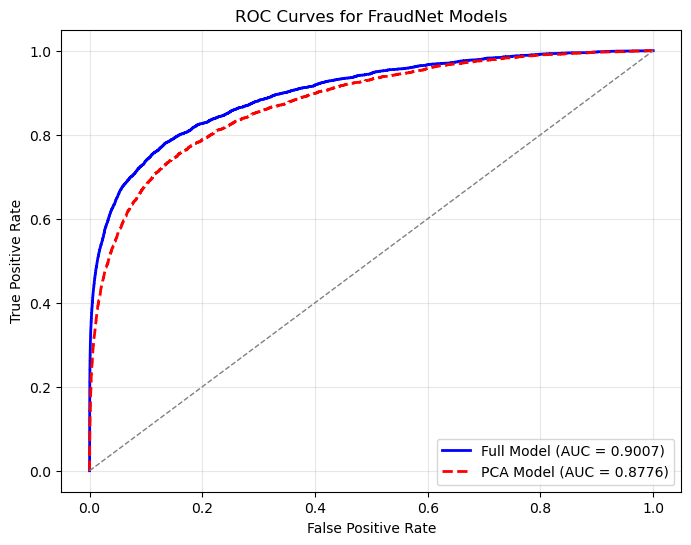

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))

# Full model ROC
fpr_full, tpr_full, _ = roc_curve(y_test_full, probs_full)
roc_auc_full = auc(fpr_full, tpr_full)
plt.plot(fpr_full, tpr_full, color='blue', lw=2, label=f'Full Model (AUC = {roc_auc_full:.4f})')

# PCA model ROC
fpr_pca, tpr_pca, _ = roc_curve(y_test_pca, probs_pca)
roc_auc_pca = auc(fpr_pca, tpr_pca)
plt.plot(fpr_pca, tpr_pca, color='red', lw=2, linestyle='--', label=f'PCA Model (AUC = {roc_auc_pca:.4f})')

# Random chance line
plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--')

# Labels and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for FraudNet Models")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


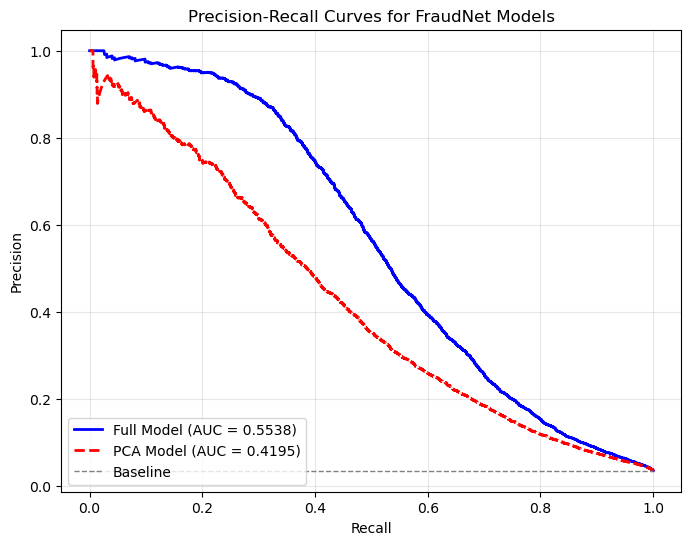

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

plt.figure(figsize=(8,6))

# Full model PR
precision_full, recall_full, _ = precision_recall_curve(y_test_full, probs_full)
pr_auc_full = auc(recall_full, precision_full)
plt.plot(recall_full, precision_full, color='blue', lw=2, label=f'Full Model (AUC = {pr_auc_full:.4f})')

# PCA model PR
precision_pca, recall_pca, _ = precision_recall_curve(y_test_pca, probs_pca)
pr_auc_pca = auc(recall_pca, precision_pca)
plt.plot(recall_pca, precision_pca, color='red', lw=2, linestyle='--', label=f'PCA Model (AUC = {pr_auc_pca:.4f})')

# Baseline (positive class proportion)
baseline = y_test_full.mean()
plt.hlines(baseline, 0, 1, color='gray', lw=1, linestyle='--', label='Baseline')

# Labels and title
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves for FraudNet Models")
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.show()


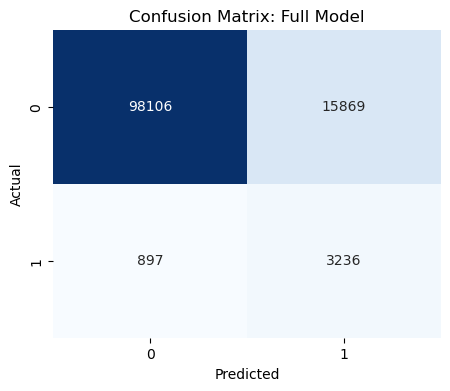

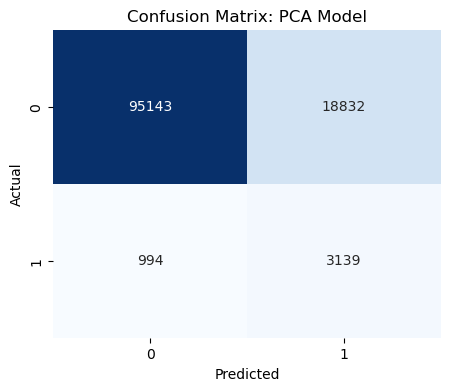

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, model_name="Model"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()

# Compute predicted labels
y_pred_full = (probs_full >= 0.5).astype(int)
y_pred_pca  = (probs_pca >= 0.5).astype(int)

# Plot confusion matrices
plot_confusion_matrix(y_test_full, y_pred_full, "Full Model")
plot_confusion_matrix(y_test_pca,  y_pred_pca,  "PCA Model")
